In [1]:
import os
os.getcwd()

'c:\\Users\\Alpha\\AppData\\Local\\Programs\\Microsoft VS Code'

In [6]:
os.chdir('C:/Users/Alpha/Downloads')

In [8]:
os.listdir()

['16781_islomuz.pdf',
 '2025-template_bullet.docx',
 '636152513-L-Tafsiri-Hilol-2-juz.pdf',
 '636152523-Tafsiri-Hilol-1-juz.pdf',
 'Accessible-MCS-Resume-Template-Bullet-Points.docx',
 'book1.pdf',
 'Cash Flow154918600.zip',
 'desktop.ini',
 'GlitteringRevolvingBoaconstrictor.mp4',
 'Guns.dta',
 'Hilol-eBook-installer_2.0.3.exe',
 'Lecture Plan.pdf',
 'letsvpn-latest.exe',
 'ML Machine Learning-A Probabilistic Perspective.pdf',
 'Patents Applied and Obtained at Home and Abroad014815152.zip',
 'RD Investment141823660.zip',
 'Telegram Desktop',
 'Untitled.png',
 '~$ teaching plan-English fun class.doc',
 "关于2025年硕士研究生学位论文中期进展报告、中期考核的通知 Notice of Mid-term Progress Report & Mid-Term Review on 2025 Master's Degree Thesis.zip"]

In [20]:
df.columns

Index(['year', 'vio', 'mur', 'rob', 'incarc_rate', 'pb1064', 'pw1064',
       'pm1029', 'pop', 'avginc', 'density', 'stateid', 'shall'],
      dtype='object')

In [22]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('Guns.csv', usecols = ['stateid', 'year', 'avginc', 'vio'],
 index_col = ['stateid', 'year'])

In [25]:
dataset

vio     avginc year
stateid year                       
1       77    414.4   9.563149   77
        78    419.1   9.932000   78
        79    413.3   9.877028   79
        80    448.5   9.541428   80
        81    470.5   9.548351   81
...             ...        ...  ...
56      95    254.2  14.070156   95
        96    249.7  14.032229   96
        97    255.2  14.790978   97
        98    247.6  15.225509   98
        99    232.3  15.765074   99

[1173 rows x 3 columns]

In [24]:
years = dataset.index.get_level_values('year').to_list()
dataset['year'] = pd.Categorical(years)

Assumotions:
These assumptions are (1) Linearity, (2) Exogeneity, (3a) Homoskedasticity and (3b) Non-autocorrelation, (4) Independent variables are not Stochastic and (5) No Multicolinearity.

If assumption (2) or (3) (or both) are violated, then FE or RE might be more suitable.

In [26]:
# Perform PooledOLS
from linearmodels import PooledOLS
import statsmodels.api as sm

exog = sm.tools.tools.add_constant(dataset['avginc'])
endog = dataset['vio']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)

# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

Check condition 3:



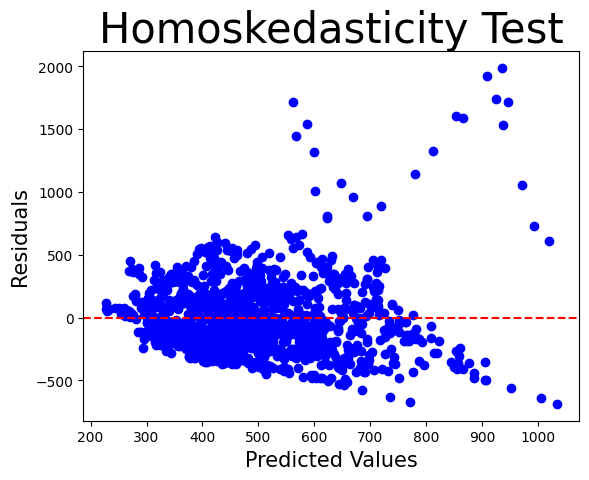

In [27]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt

 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

Basically, a residuals-plot represents predicted values (x-axis) vs. residuals (y-axis). If the plotted data points spread out, this is an indicator for growing variance and thus, for heteroskedasticity. Since this seems to be the case in our example, we might have the first violation. But let´s check this with the White- and the Breusch-Pagan-Test:

In [29]:

# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([dataset, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['year'], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(dataset['avginc']).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))

# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': np.float64(200.15502493784587), 'LM p-val': np.float64(3.442615915038229e-44), 'F-Stat': np.float64(120.3590423861304), 'F p-val': np.float64(2.9254476143351516e-48)}
{'LM-Stat': np.float64(110.96166679034808), 'LM p-val': np.float64(6.032597654720378e-26), 'F-Stat': np.float64(122.34597165509983), 'F p-val': np.float64(4.048123317703663e-27)}


Therefore, we have proven our first violation! Let´s perform assumption 3b:

In [30]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

0.08937263778978369


The Durbin-Watson-Test will have one output between 0 – 4. The mean (= 2) would indicate that there is no autocorrelation identified, 0 – 2 means positive autocorrelation (the nearer to zero the higher the correlation), and 2 – 4 means negative autocorrelation (the nearer to four the higher the correlation). In our example, the result is 0.08937264851640213, which clearly indicates strong positive autocorrelation.

As a consequence, assumption 3b is also violated, so it seems that a FE-/RE-model will be more suitable.

Step 3: Perform FE- and RE-model



In [32]:
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects
exog = sm.tools.tools.add_constant(dataset['avginc'])
endog = dataset['vio']

# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 

# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 

#print results
print(re_res)
print(fe_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                    vio   R-squared:                        0.1128
Estimator:              RandomEffects   R-squared (Between):              0.1159
No. Observations:                1173   R-squared (Within):               0.1127
Date:                Mon, Oct 06 2025   R-squared (Overall):              0.1156
Time:                        03:14:59   Log-likelihood                   -7109.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      148.90
Entities:                          51   P-value                           0.0000
Avg Obs:                       23.000   Distribution:                  F(1,1171)
Min Obs:                       23.000                                           
Max Obs:                       23.000   F-statistic (robust):             148.90
                            

In this example, both perform similar (although, FE seems to perform slightly better). So, in order to test which model should be preferred, we will finally perfom the Hausman-test.

Step 4: Perform Hausman-Test



In [40]:
import numpy.linalg as la
from scipy import stats
import numpy as np
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    dataset = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 

    pval = stats.chi2.sf(chi2, dataset)
    return chi2, dataset, pval
hausman_results = hausman(fe_res, re_res) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 9.426374052689594
degrees of freedom: 2
p-Value: 0.008976124801888039


In [ ]:
dataset 

vio     avginc year
stateid year                       
1       77    414.4   9.563149   77
        78    419.1   9.932000   78
        79    413.3   9.877028   79
        80    448.5   9.541428   80
        81    470.5   9.548351   81
...             ...        ...  ...
56      95    254.2  14.070156   95
        96    249.7  14.032229   96
        97    255.2  14.790978   97
        98    247.6  15.225509   98
        99    232.3  15.765074   99

[1173 rows x 3 columns]